In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [3]:
%cd /content/drive/MyDrive/pipinstall/network_data
!ls

/content/drive/MyDrive/pipinstall/network_data
NUSW-NB15_features.csv	UNSW-NB15_2.csv  UNSW-NB15_4.csv	    UNSW_NB15_testing-set.csv
UNSW-NB15_1.csv		UNSW-NB15_3.csv  UNSW-NB15_LIST_EVENTS.csv  UNSW_NB15_training-set.csv


In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import time
import matplotlib.pyplot as plt
import sklearn
import xgboost as xgb
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder,MinMaxScaler,StandardScaler
from sklearn import svm
from sklearn.metrics import classification_report,roc_auc_score,average_precision_score,confusion_matrix
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score

In [4]:
df_train =pd.read_csv('UNSW_NB15_testing-set.csv')
df_test = pd.read_csv('UNSW_NB15_training-set.csv')

In [5]:
df_train.head()

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,...,1,1,0,0,0,1,1,0,Normal,0
1,2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,...,1,2,0,0,0,1,6,0,Normal,0
2,3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,...,1,3,0,0,0,2,6,0,Normal,0
3,4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,...,1,3,1,1,0,2,1,0,Normal,0
4,5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,...,1,40,0,0,0,2,39,0,Normal,0


In [6]:
df_test.head(5)

,id,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,...,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,attack_cat,label
0,1,0.000011,udp,-,INT,2,0,496,0,90909.0902,...,1,2,0,0,0,1,2,0,Normal,0
1,2,0.000008,udp,-,INT,2,0,1762,0,125000.0003,...,1,2,0,0,0,1,2,0,Normal,0
2,3,0.000005,udp,-,INT,2,0,1068,0,200000.0051,...,1,3,0,0,0,1,3,0,Normal,0
3,4,0.000006,udp,-,INT,2,0,900,0,166666.6608,...,1,3,0,0,0,2,3,0,Normal,0
4,5,0.000010,udp,-,INT,2,0,2126,0,100000.0025,...,1,3,0,0,0,2,3,0,Normal,0


In [7]:
df = pd.concat([df_train, df_test])
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 257673 entries, 0 to 82331
Data columns (total 45 columns):
 #   Column             Non-Null Count   Dtype  
---  ------             --------------   -----  
 0   id                 257673 non-null  int64  
 1   dur                257673 non-null  float64
 2   proto              257673 non-null  object 
 3   service            257673 non-null  object 
 4   state              257673 non-null  object 
 5   spkts              257673 non-null  int64  
 6   dpkts              257673 non-null  int64  
 7   sbytes             257673 non-null  int64  
 8   dbytes             257673 non-null  int64  
 9   rate               257673 non-null  float64
 10  sttl               257673 non-null  int64  
 11  dttl               257673 non-null  int64  
 12  sload              257673 non-null  float64
 13  dload              257673 non-null  float64
 14  sloss              257673 non-null  int64  
 15  dloss              257673 non-null  int64  
 16  sinpkt  

In [8]:
df.describe()

,id,dur,spkts,dpkts,sbytes,dbytes,rate,sttl,dttl,sload,...,ct_src_dport_ltm,ct_dst_sport_ltm,ct_dst_src_ltm,is_ftp_login,ct_ftp_cmd,ct_flw_http_mthd,ct_src_ltm,ct_srv_dst,is_sm_ips_ports,label
count,257673.000000,257673.000000,257673.000000,257673.000000,2.576730e+05,2.576730e+05,2.576730e+05,257673.000000,257673.000000,2.576730e+05,...,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000,257673.000000
mean,72811.823858,1.246715,19.777144,18.514703,8.572952e+03,1.438729e+04,9.125391e+04,180.000931,84.754957,7.060869e+07,...,5.238271,4.032677,8.322964,0.012819,0.012850,0.132005,6.800045,9.121049,0.014274,0.639077
std,48929.917641,5.974305,135.947152,111.985965,1.737739e+05,1.461993e+05,1.603446e+05,102.488268,112.762131,1.857313e+08,...,8.160822,5.831515,11.120754,0.116091,0.116421,0.681854,8.396266,10.874752,0.118618,0.480269
min,1.000000,0.000000,1.000000,0.000000,2.400000e+01,0.000000e+00,0.000000e+00,0.000000,0.000000,0.000000e+00,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000
25%,32210.000000,0.000008,2.000000,0.000000,1.140000e+02,0.000000e+00,3.078928e+01,62.000000,0.000000,1.231800e+04,...,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,2.000000,2.000000,0.000000,0.000000
50%,64419.000000,0.004285,4.000000,2.000000,5.280000e+02,1.780000e+02,2.955665e+03,254.000000,29.000000,7.439423e+05,...,1.000000,1.000000,3.000000,0.000000,0.000000,0.000000,3.000000,4.000000,0.000000,1.000000
75%,110923.000000,0.685777,12.000000,10.000000,1.362000e+03,1.064000e+03,1.250000e+05,254.000000,252.000000,8.000000e+07,...,4.000000,3.000000,8.000000,0.000000,0.000000,0.000000,8.000000,11.000000,0.000000,1.000000
max,175341.000000,59.999989,10646.000000,11018.000000,1.435577e+07,1.465753e+07,1.000000e+06,255.000000,254.000000,5.988000e+09,...,59.000000,46.000000,65.000000,4.000000,4.000000,30.000000,60.000000,62.000000,1.000000,1.000000


In [9]:
df.isnull().sum()

id                   0
dur                  0
proto                0
service              0
state                0
spkts                0
dpkts                0
sbytes               0
dbytes               0
rate                 0
sttl                 0
dttl                 0
sload                0
dload                0
sloss                0
dloss                0
sinpkt               0
dinpkt               0
sjit                 0
djit                 0
swin                 0
stcpb                0
dtcpb                0
dwin                 0
tcprtt               0
synack               0
ackdat               0
smean                0
dmean                0
trans_depth          0
response_body_len    0
ct_srv_src           0
ct_state_ttl         0
ct_dst_ltm           0
ct_src_dport_ltm     0
ct_dst_sport_ltm     0
ct_dst_src_ltm       0
is_ftp_login         0
ct_ftp_cmd           0
ct_flw_http_mthd     0
ct_src_ltm           0
ct_srv_dst           0
is_sm_ips_ports      0
attack_cat 

In [10]:
df = df.dropna()


In [11]:
print(df.duplicated().sum())

0


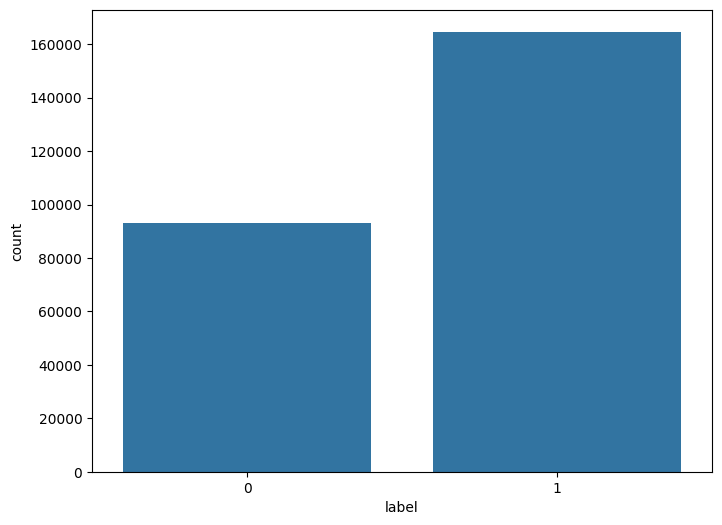

label
1    0.639077
0    0.360923
Name: proportion, dtype: float64


In [13]:
plt.figure(figsize=(8, 6))
sns.countplot(x='label', data=df)
plt.show()

# Display normalized value counts
print(df['label'].value_counts(normalize=True))

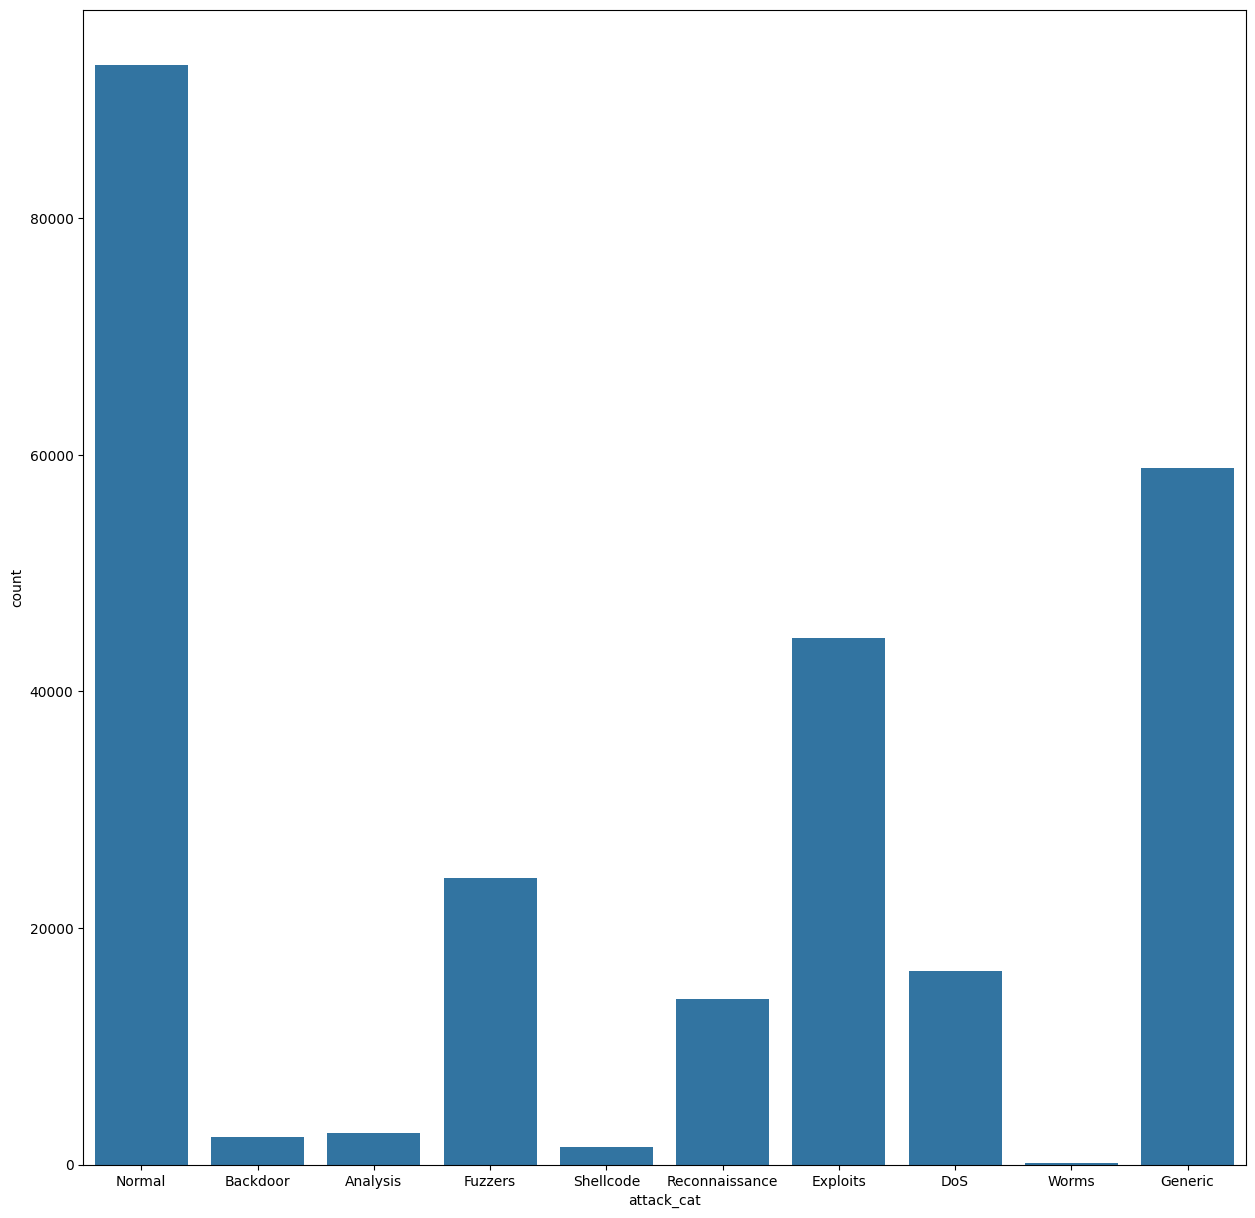

attack_cat
Normal            0.360923
Generic           0.228472
Exploits          0.172797
Fuzzers           0.094096
DoS               0.063464
Reconnaissance    0.054282
Analysis          0.010389
Backdoor          0.009039
Shellcode         0.005864
Worms             0.000675
Name: proportion, dtype: float64


In [14]:
plt.figure(figsize=(15, 15))
sns.countplot(x='attack_cat', data=df)
plt.show()

# Display normalized value counts
print(df['attack_cat'].value_counts(normalize=True))

In [15]:
attack_cat = ['Normal','Generic', 'Exploits', 'Fuzzers', 'DoS', 'Reconnaissance', 'Analysis', 'Backdoor', 'Shellcode','Worms']

In [16]:
#defining col list
cols = ['proto','state','service']
cols

['proto', 'state', 'service']

In [17]:
# One-hot encoding for the categorical features
df = pd.get_dummies(df, columns=cols, drop_first=True)


In [18]:
# Separate features (X) and target (y)
X = df.drop(columns='attack_cat')
y = df['attack_cat']


In [19]:
# List of numerical columns
numerical_cols = X.select_dtypes(include=['number']).columns.tolist()

In [20]:
# Select only numerical features
X_num = X[numerical_cols]

In [21]:
# Split the dataset into training and testing sets with 20% for testing
X_train, X_test, y_train, y_test = train_test_split(X_num, y, test_size=0.2, random_state=2)


In [22]:
# Feature scaling
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test= scaler.transform(X_test)

In [23]:
print("Training set:", len(X_train))
print("Testing set:", len(X_test))


Training set: 206138
Testing set: 51535


In [24]:

rf_model = RandomForestClassifier(random_state=42)

# model Random Forest
rf_model.fit(X_train, y_train)

y_pred_rf = rf_model.predict(X_test)

classification_report_rf = classification_report(y_test, y_pred_rf, target_names=attack_cat)

conf_matrix_rf = confusion_matrix(y_test, y_pred_rf)

print("Random Forest Results:")
print("\nClassification Report:\n", classification_report_rf)
print("\nConfusion Matrix:\n", conf_matrix_rf)


Random Forest Results:

Classification Report:
                 precision    recall  f1-score   support

        Normal       0.23      0.20      0.21       540
       Generic       0.14      0.14      0.14       472
      Exploits       0.40      0.38      0.39      3232
       Fuzzers       0.75      0.79      0.77      8923
           DoS       0.89      0.89      0.89      4957
Reconnaissance       0.99      0.98      0.99     11860
      Analysis       1.00      1.00      1.00     18431
      Backdoor       0.80      0.78      0.79      2783
     Shellcode       0.67      0.65      0.66       301
         Worms       0.40      0.11      0.17        36

      accuracy                           0.88     51535
     macro avg       0.63      0.59      0.60     51535
  weighted avg       0.88      0.88      0.88     51535


Confusion Matrix:
 [[  108    91   163   131    43     0     0     4     0     0]
 [   67    68    96   150    18     3     0    68     2     0]
 [  124    98  1212